# Use Toronto neihgbourhood data to generate meaningful location data for bikeshare locations

In [3]:
import pandas as pd
import geopandas as gpd
#import geoplot as gplt
#import geoplot.crs as gcrs
import matplotlib.pyplot as plt
import requests
import json
from shapely.geometry import shape

# Get the dataset metadata by passing package_id to the package_search endpoint
# For example, to retrieve the metadata for this dataset:

url = "https://ckan0.cf.opendata.inter.prod-toronto.ca/api/3/action/package_show"
params = { "id": "4def3f65-2a65-4a4f-83c4-b2a4aed72d46"}
package = requests.get(url, params = params).json()

# Get the data by passing the resource_id to the datastore_search endpoint
# See https://docs.ckan.org/en/latest/maintaining/datastore.html for detailed parameters options
# For example, to retrieve the data content for the first resource in the datastore:

for idx, resource in enumerate(package["result"]["resources"]):
    #print(resource)
    if resource["datastore_active"]:
        url = "https://ckan0.cf.opendata.inter.prod-toronto.ca/api/3/action/datastore_search"
        p = { "id": resource["id"], "limit": 32000 }
        data = requests.get(url, params = p).json()
        df = pd.DataFrame(data["result"]["records"])
        break
        
#define function to parse the geometry column
#This is not extremely efficient but I can't figure out how another work around 
#besides downloading the JSON file and useing gpd.read_file
def parse_geom(geom_str):
    return shape(json.loads(geom_str))
    try:
        return shape(json.loads(geom_str))
    except (TypeError, AttributeError):  # Handle NaN and empty strings
        return None
#assign the function to the correct column
df["geometry"] = df["geometry"].apply(parse_geom)

#turn this into a geopandas dataframe
gdf = gpd.GeoDataFrame(df, geometry="geometry")

[{'cache_last_updated': None, 'package_id': '4def3f65-2a65-4a4f-83c4-b2a4aed72d46', 'datastore_active': True, 'id': 'a083c865-6d60-4d1d-b6c6-b0c8a85f9c15', 'size': None, 'format': 'GeoJSON', 'state': 'active', 'hash': '', 'description': '', 'is_preview': True, 'last_modified': '2021-03-15T10:20:08.000096', 'url_type': 'datastore', 'mimetype': None, 'cache_url': None, 'extract_job': 'B1_Neighbourhoods', 'name': 'Neighbourhoods', 'created': '2019-07-23T17:47:39.596503', 'url': 'https://ckan0.cf.opendata.inter.prod-toronto.ca/datastore/dump/a083c865-6d60-4d1d-b6c6-b0c8a85f9c15', 'mimetype_inner': None, 'position': 0, 'revision_id': '93224426-867b-4646-9c91-9fdce1f0247d', 'resource_type': None}]
     _id  AREA_ID  AREA_ATTR_ID PARENT_AREA_ID AREA_SHORT_CODE AREA_LONG_CODE  \
0  11481  2480141      26005521           None             096            096   
1  11482  2480140      26005520           None             095            095   
2  11483  2480139      26005519           None          

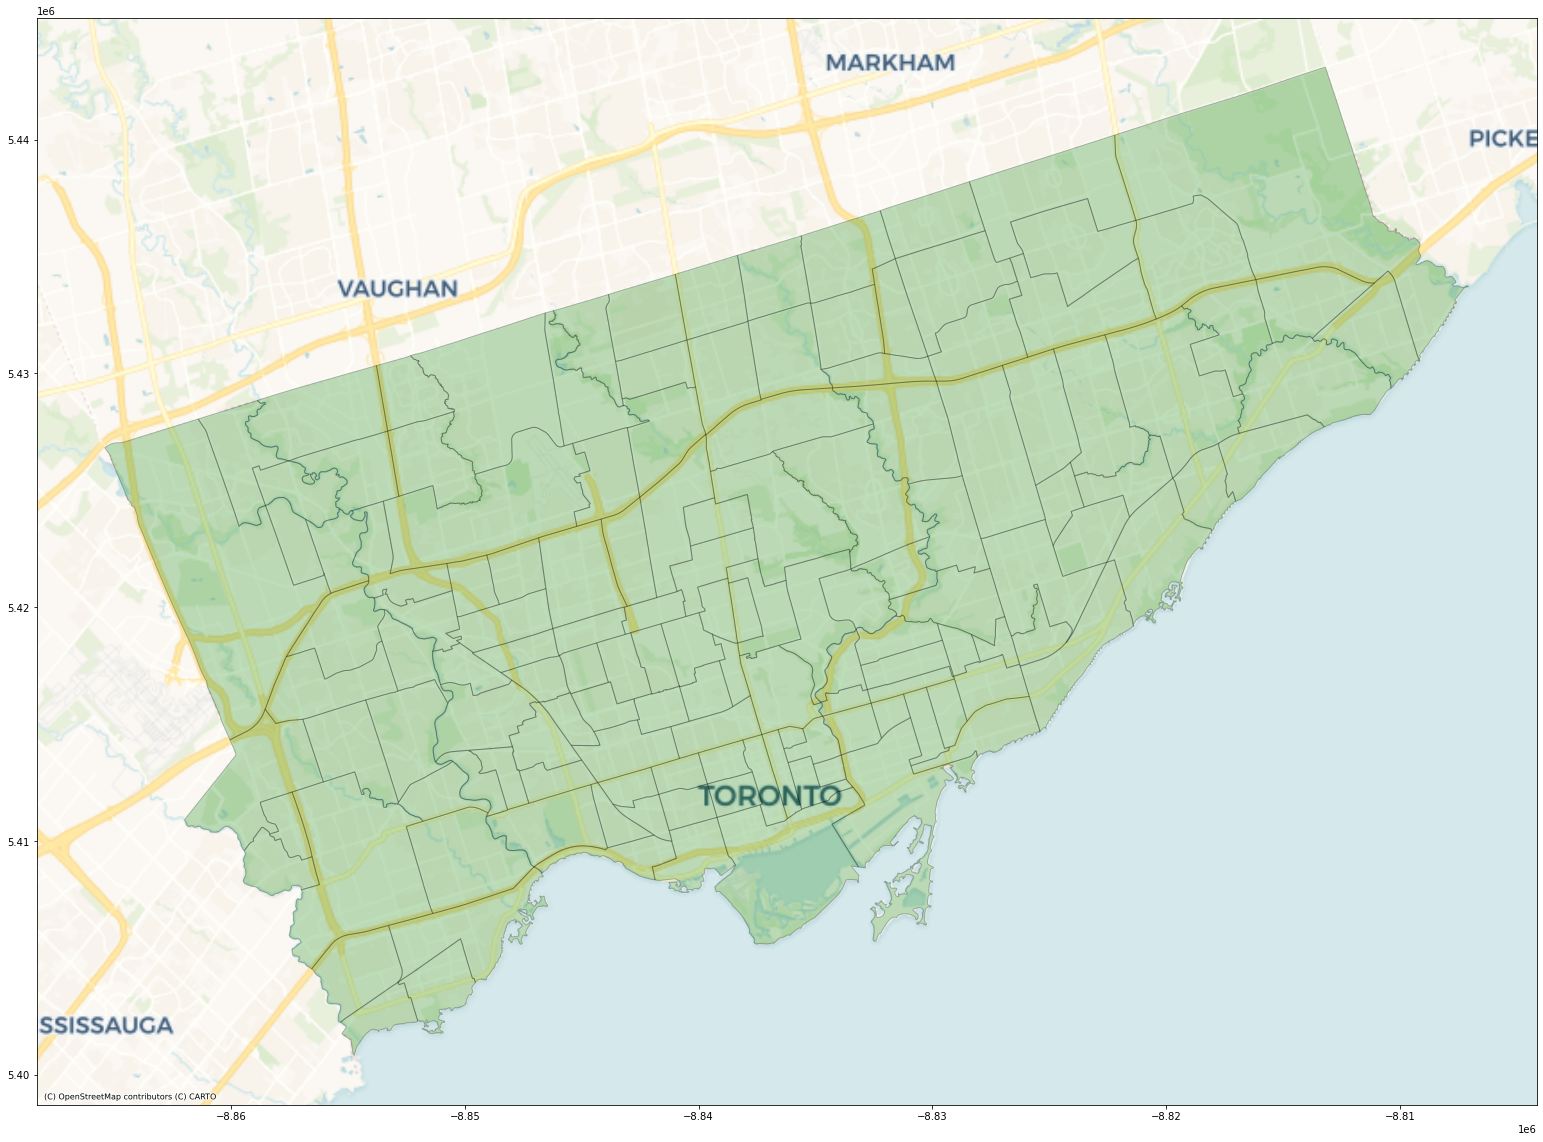

In [6]:
import contextily as cx#for adding base map

#turn this into a geopandas dataframe
gdf = gpd.GeoDataFrame(df, geometry="geometry")
#set coordinates system
gdf = gdf.set_crs("EPSG:4326")
gdf = gdf.to_crs(epsg=3857)# alternatively you can use the crs paramter in add_basemap to change that id hte dataset is too large
ax = gdf.plot(figsize=(40,20), color = 'g', alpha = 0.25, edgecolor = 'k')
cx.add_basemap(ax,zoom = 11, source=cx.providers.CartoDB.Voyager)
